# Merchant Categorisation

The objective of this exercise is to be able to segment merchants into significantly different categories based on **key attributes** that we can extract from the available data.
The data we have available is that of around 1.5 million transactions across 2 years for 14,351 customers. I make the following general assumption about this data-

1. Each merchant present in this dataset only uses stripe and so we have 100% of their trnsactions in this data.
2. All merchants fall in the same timezone


In [1]:
import pandas as pd
import os
import project_s.src as src
import project_s.src.common_utils as utils
import math
from plotnine import *
pd.DataFrame.removeUnivarOutliers = utils.remove_univariate_outliers
import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_data = pd.read_csv(os.path.join(src.dir_path , "data/raw/takehome_ds_written.csv"),index_col=0,parse_dates = ["time"])

In [3]:
#Null check
null_count = raw_data.apply(  lambda x : sum(pd.isna(x))/len(x))
unqiue_customers = raw_data["merchant"].nunique()
# DIstribution check

## Distrubution of merchant features

In [4]:
# Understanding merchant activity Featuer distribition for merchants
merchant_features = (raw_data.
    assign(amount_in_usd = lambda x : x.amount_usd_in_cents/100 ,
          year = lambda x : x.time.dt.strftime('%Y'),
          year_month = lambda x : x.time.dt.strftime('%Y-%m'),
          weekend_indicator = lambda x : x.time.dt.weekday.gt(4),
          peak_window_indicator = lambda x : (x.time.dt.strftime('%H').astype(int) >=15) | (x.time.dt.strftime('%H').astype(int) <=3),
          date = lambda x : x.time.dt.strftime('%Y-%m-%d')).
    groupby("merchant").
    agg(total_amount_usd =  ('amount_in_usd','sum'),
        count_txns = ('amount_in_usd','count'),
        count_weekend_txns = ('weekend_indicator', 'sum'),
        count_peak_window_txns = ('peak_window_indicator', 'sum'),
        avg_txn_amount = ('amount_in_usd','mean'),
        transaction_days = ('date','nunique'),
        first_transaction_day = ('date','min'),
        last_transaction_day = ('date','max')).
     assign(first_transaction_day  = lambda x : pd.to_datetime(x.first_transaction_day) ,
             last_transaction_day  = lambda x : pd.to_datetime(x.last_transaction_day) ,  
             activity_duration =  lambda x : (x.last_transaction_day - x.first_transaction_day).dt.days + 1 ,
             days_bw_transactions = lambda x : x.activity_duration/(x.count_txns-1) ,
             transaction_per_day = lambda x : x.count_txns/x.activity_duration,
             perc_weekend_txns = lambda x : x.count_weekend_txns/x.count_txns,
            perc_peak_window_txns = lambda x : x.count_peak_window_txns/x.count_txns)
    )
merchant_features.loc[lambda x : x.count_txns>5].describe(pd.np.linspace(0,1,11))

,total_amount_usd,count_txns,count_weekend_txns,count_peak_window_txns,avg_txn_amount,transaction_days,activity_duration,days_bw_transactions,transaction_per_day,perc_weekend_txns,perc_peak_window_txns
count,9.149000e+03,9149.000000,9149.000000,9149.000000,9149.000000,9149.000000,9149.000000,9149.000000,9149.000000,9149.000000,9149.000000
mean,2.495361e+04,164.021860,43.104820,124.903705,310.918030,50.585856,278.924691,12.413963,1.594440,0.240665,0.748583
std,7.917787e+04,653.750589,188.931226,501.185820,1124.948013,84.776537,203.849779,17.332963,18.666326,0.183396,0.202662
min,1.589000e+01,6.000000,0.000000,0.000000,2.270000,1.000000,1.000000,0.000596,0.008824,0.000000,0.000000
0%,1.589000e+01,6.000000,0.000000,0.000000,2.270000,1.000000,1.000000,0.000596,0.008824,0.000000,0.000000
10%,5.193860e+02,7.000000,0.000000,5.000000,37.479582,5.800000,24.000000,0.500000,0.033041,0.000000,0.500000
20%,9.792180e+02,10.000000,1.000000,7.000000,52.376098,7.000000,66.000000,1.215197,0.054422,0.088235,0.631579
30%,1.632574e+03,14.000000,2.000000,10.000000,64.748003,9.000000,124.000000,2.128536,0.082853,0.142857,0.700000
40%,2.667990e+03,19.000000,4.000000,14.000000,81.192587,13.000000,186.000000,3.484444,0.123457,0.181818,0.745859
50%,4.281230e+03,28.000000,6.000000,20.000000,105.272727,18.000000,255.000000,5.515152,0.188742,0.222826,0.782609


The above table helps us get a sense of the distribution of several key merchant features. Merchants with less than 5 transactions have been skipped.The following features have been computed at a merchant level - 

1. count_txns : Total number of transactions
2. count_weekend_txns : Total number of transactions that happened on a weekend
3. count_peak_window_txns : Count of transactions that happened during the daily window of 3pm to 3am (see below pn how i came up with this)
4. avg_txn_amount : Average transaction amount
5. transaction_days : number of unique days on which the merchant transacted
6. activity_duration : time period in days from first to last transaction for the merchant
7. days_bw_transactions : average days between consecutive transactions for the merchant
8. transaction_per_day : Average transactions per day within the activity_duration
9. perc_weekend_txns : Percentage of transactions that happened on the weekend
9. perc_peak_window_txns : Percentage of transactions that happened during the daily window of 3pm to 3am

I did not venture into the time distribution of trnsactions beyond weekly since we have limited data. If we had data for a few more years, we could make out some quarterly/monthly trends as well. I have also ignored merchants with less than 5 transactions within the 2 year period since getting statistically relevant features for these merchants would not be possible and we should probably wait for more data on them before we categorize them.

A few trends jump out by looking at the distributions.

1. The average ticket size is log normally distributed i.e. around 80% of the population has an average of ~300 usd, but there is a fat tail wehre a few merchants have really high average transation sizes.
2. The average days between transactions has a similar disrtibution where the median average days bw consecutive transactions is around 5 days.
3. Almost half the merchants have 80% or more of their transactions happening in the 12 hour window from 3pm to 3am.

### Distribution of transactions across the day

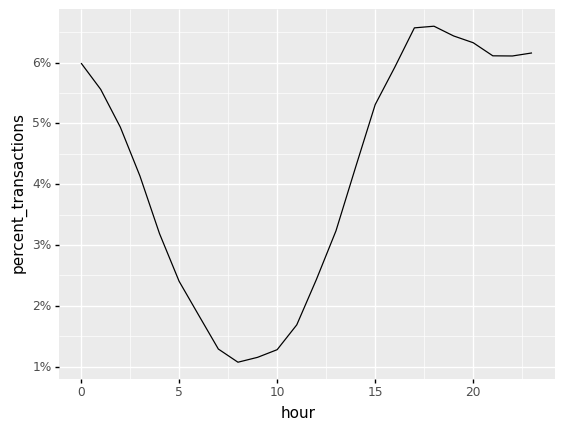

<ggplot: (-9223371925836736312)>

In [5]:
# Distribution of trnsactions with time

time_distribution_df = pd.DataFrame(raw_data["time"].dt.strftime('%H').astype(int).value_counts(normalize = True).sort_index().reset_index())
time_distribution_df.rename(columns = {"index" : "hour", "time":"percent_transactions"},inplace= True)
ggplot(time_distribution_df , aes(x = "hour" , y = "percent_transactions")) + geom_line()  + scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l])


There is significantly more activity in the 12 hour window from 1500 to 0300 than the rest of the day. It would be interesting to see if this is contributed by a specific category of merchants.

### Distribution of average days between consecutive transactions

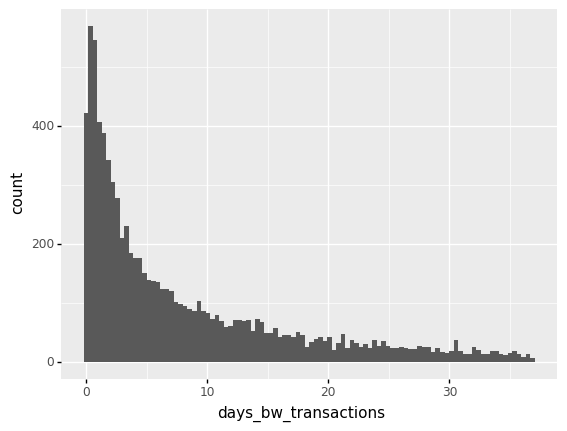

<ggplot: (-9223371925728364140)>

In [6]:
ggplot(merchant_features.loc[lambda x : x.count_txns>5].removeUnivarOutliers(["days_bw_transactions"]),aes(x = "days_bw_transactions")) + geom_histogram(bins=100)

### Distribution of average transaction size in dollars

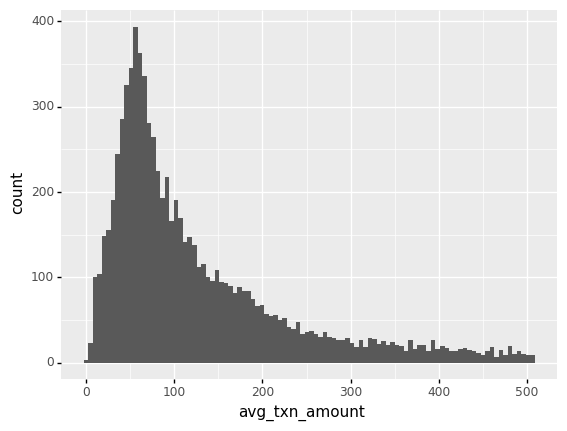

<ggplot: (-9223371925724492552)>

In [7]:
ggplot(merchant_features.loc[lambda x : x.count_txns>5].removeUnivarOutliers(["avg_txn_amount"]),aes(x = "avg_txn_amount")) + geom_histogram(bins=100)

# Relation between average ticket size and frequency 

(8912, 2)


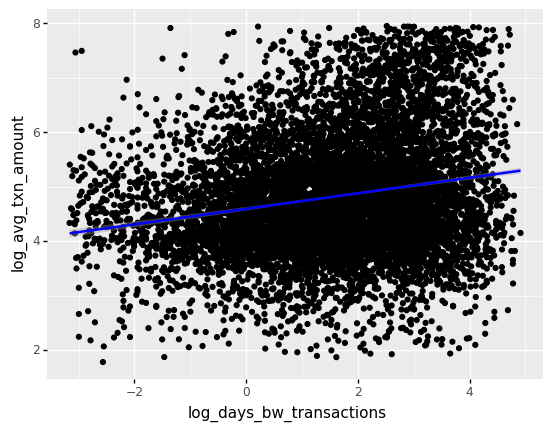

<ggplot: (-9223371925856711636)>

In [8]:

merchant_features_cln = utils.remove_univariate_outliers(merchant_features.assign(log_avg_txn_amount = lambda x : x.avg_txn_amount.apply(math.log),
                                                                           log_days_bw_transactions = lambda x : x.days_bw_transactions.apply(math.log)), 
                                                   ["log_days_bw_transactions","log_avg_txn_amount"]).loc[lambda x: x.count_txns>5,["log_days_bw_transactions","log_avg_txn_amount"]]
print(merchant_features_cln.shape)
ggplot(merchant_features_cln,aes(x = 'log_days_bw_transactions' , y = 'log_avg_txn_amount')) + geom_point( ) + geom_smooth(color = "blue")

Above is a scatter plot between the average ticket size and the average fays between transactions for all merchants. Both axis are on a log scale.
CLearly There is a significant correlation of the frequency(inverse of average days bw transactions) of transactions with ticket size. As frequency increases, merchants are likely to be lower ATS. The relationship seems to be almost linear albeit with some heteroskedasticity as the variation of ticket size is much higher amoug merchants with lower transaction frequencies(higher average days between transactions).

# Running a simple clustering model

From the above exploratory data analysis, the features that make the most business sense would be the average transactions size of the customer, captured by the average dollar transaction size , and the frequency of trnsactions, captured by the average days between transactions.

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
merchant_features_cln_scaled = scaler.fit_transform(merchant_features_cln)

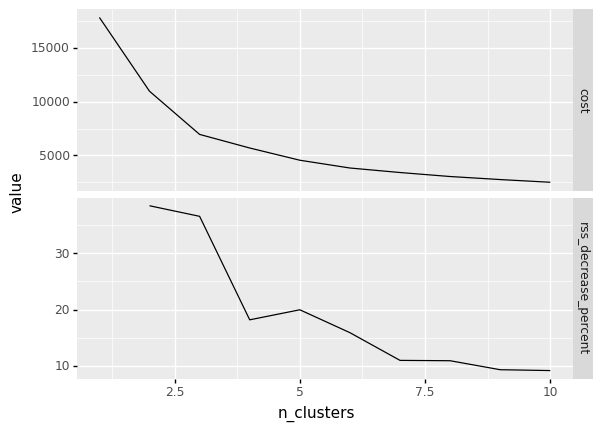

<ggplot: (-9223371925856160636)>

In [10]:
cost =[]
for i in range(1, 11):
    KM = KMeans(n_clusters = i, max_iter = 500,random_state=42)
    KM.fit(merchant_features_cln_scaled)
     
    # calculates squared error
    # for the clustered points
    cost.append({"n_clusters":i , "cost":KM.inertia_})   


cost_df = pd.DataFrame(cost).assign( rss_decrease_percent = lambda x : ((x.cost.shift(1) - x.cost)/x.cost.shift(1))*100 ).melt("n_clusters")
ggplot(cost_df, aes(x = "n_clusters", y = "value")) + geom_line() +facet_grid('variable ~ .', scales = 'free')

### Choosing the optimum number of clusters

Beyond 3 clusters, the decrease in the unexplained variance(in pecentage terms) drops sharply. So I have chosen 3 clusters to be the optimal for this case.

In [12]:
KM = KMeans(n_clusters = 3, max_iter = 500,random_state=42)
KM.fit(merchant_features_cln_scaled)


KMeans(max_iter=500, n_clusters=3, random_state=42)

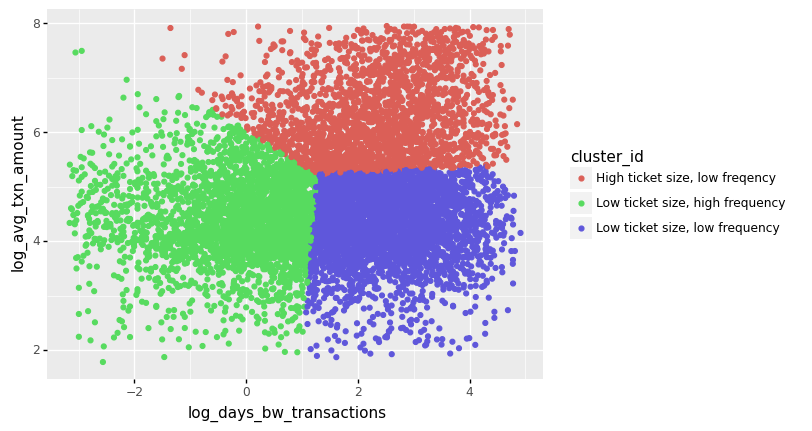

<ggplot: (-9223371925855044164)>

In [13]:
merchant_features_cln["cluster_id"] = list(KM.labels_)
merchant_features_cln["cluster_id"] = merchant_features_cln["cluster_id"].astype(str).replace({"0":"Low ticket size, high frequency",
                                                                                               "2":"Low ticket size, low frequency",
                                                                                               "1" : "High ticket size, low freqency"})
ggplot(merchant_features_cln,aes(x = 'log_days_bw_transactions' , y = 'log_avg_txn_amount',color = 'cluster_id')) + geom_point( ) 

Visualising the clusters in log space, the clusters represent 3 distinct categories - 

1. Merchants who transact frequently and have low average days between transactions.
2. Merchants who transact infrequently but have a higher average transaction size when they transact.
3. Merchants who transact infrequently and also have a lower average transaction size when they transact.

The below density charts highlight the differences in these segments clearly -

In [17]:
merchant_features_clustered = merchant_features.merge(merchant_features_cln, left_index = True , right_index = True)
(merchant_features_clustered
    .loc[:,["days_bw_transactions","avg_txn_amount","cluster_id"]]
    .groupby("cluster_id")
    .describe()).to_clipboard()

# ggplot(merchant_features_clustered.removeUnivarOutliers(["avg_txn_amount"]),aes(x = "avg_txn_amount", fill = "cluster_id")) + geom_density( alpha = 0.5)

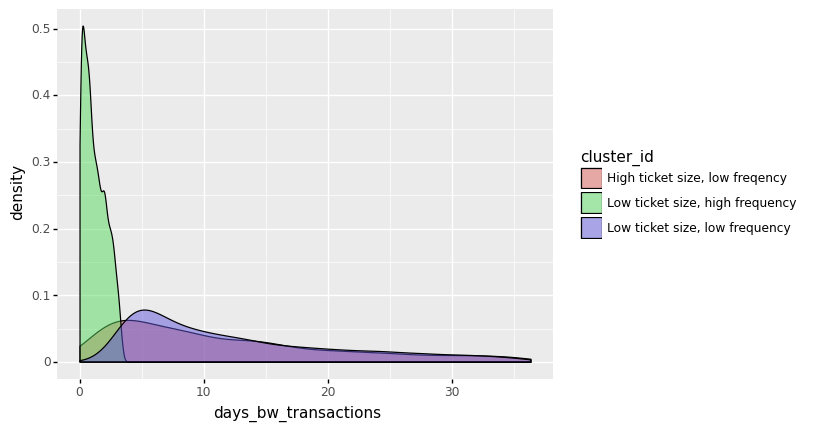

<ggplot: (-9223371888873523908)>

In [16]:
ggplot(merchant_features_clustered.removeUnivarOutliers(["days_bw_transactions"]),aes(x = "days_bw_transactions", fill = "cluster_id")) + geom_density( alpha = 0.5)

## Limitations

- Have not explored the distributions of payment amounts and the frequency of payments, just used averages, further information can be derived from nuances in the distributions and joint distributions. Eg subscriptions etc.
- Have not explored the dimension of how merchants are different in the time window in which hey operate. Almost half the merchants have 80% of more trnsactions in the time window between 3pm to 3am. This can be a very valuable dimension for us.

## Possible use cases 
The different segments need a different kind of service from stripe. For example, merchants where the frequency of transactions are high but the ticket size is low, we could work on automating and reducing any operational costs since they would be incurred for each transaction. We can also be more confortable with the risk in these cases since the ticket sizes are low and any single transaction being fraudulent does not have a very high cost realtive to the revenue generated by the merchant for us. Similarly merchants with high average ticket sizes and do not transact frequently need stricter fraud checks.



In [23]:
merchant_features.merge(merchant_features_cln, left_index = True , right_index = True,how = "left")["cluster_id"].fillna("unclassified").to_csv(os.path.join(src.dir_path , "data/processed/merchant_categories.csv"))